In [1]:
import arviz as az
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from scipy.special import expit as logistic

warnings.simplefilter(action="ignore", category=FutureWarning)

RANDOM_SEED = 1234567

az.style.use("arviz-darkgrid")

In [2]:
UCB_data = '../../data/ucbadmit.csv'

In [3]:
df = pd.read_csv(UCB_data)
df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [4]:
df['applications_by_dept'] = df.groupby('dept')['applications'].transform('sum')

In [5]:
df['fraction_admitted'] = df['admit'] / df['applications']
df['frac_applicants'] = df['applications'] / df['applications_by_dept']
df

,dept,applicant.gender,admit,reject,applications,applications_by_dept,fraction_admitted,frac_applicants
1,A,male,512,313,825,933,0.620606,0.884244
2,A,female,89,19,108,933,0.824074,0.115756
3,B,male,353,207,560,585,0.630357,0.957265
4,B,female,17,8,25,585,0.680000,0.042735
5,C,male,120,205,325,918,0.369231,0.354031
6,C,female,202,391,593,918,0.340641,0.645969
7,D,male,138,279,417,792,0.330935,0.526515
8,D,female,131,244,375,792,0.349333,0.473485
9,E,male,53,138,191,584,0.277487,0.327055
10,E,female,94,299,393,584,0.239186,0.672945


## Model I

We wish to model the probability of admission, given the gender of the applicant. In the first pass, we ignore the department where admissions are being sought. 

The model is as follows:
\begin{align*}
    A_i                    & \sim \text{Binomial} (N_i, p_i) \\
    \text{logit}(p_i)      & \sim \alpha_{\text{gender}[i]}  \\
    \alpha_{\text{male}}   & \sim \text{Normal}(0, 1.5)      \\
    \alpha_{\text{female}} & \sim \text{Normal}(0, 1.5)
\end{align*}

Here $N_i$ is the number of applicants in row $i$ and $\alpha$ is an intercept term that may vary by gender. 

In [6]:
gender_ids, gender = pd.factorize(df['applicant.gender'])

with pm.Model() as m_11_7:
    a = pm.Normal('a', mu=0, sigma=1.5, shape=df['applicant.gender'].nunique())
    gender_id = pm.intX(pm.Data('gender_id', gender_ids))
    p = pm.Deterministic('p', pm.math.invlogit(a[gender_id]))
    
    admit = pm.Binomial('admit', n=df['applications'], p=p, observed=df['admit'])
    
    trace_11_7 = pm.sample(2000, tune=2000, return_inferencedata=False, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


In [7]:
az.summary(trace_11_7, var_names=['a'], round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.22,0.04,-0.28,-0.16,0.0,0.0,6881.64,5693.70,1.0
a[1],-0.83,0.05,-0.91,-0.75,0.0,0.0,6387.99,5202.95,1.0


### Code 11.30

In [8]:
df_11_7 = pm.trace_to_dataframe(trace_11_7)
df_11_7.head()

,a__0,a__1,p__0,p__1,p__2,p__3,p__4,p__5,p__6,p__7,p__8,p__9,p__10,p__11
0,-0.264973,-0.918664,0.434142,0.285230,0.434142,0.285230,0.434142,0.285230,0.434142,0.285230,0.434142,0.285230,0.434142,0.285230
1,-0.247984,-0.876756,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851
2,-0.247984,-0.876756,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851,0.438320,0.293851
3,-0.192547,-0.936629,0.452012,0.281582,0.452012,0.281582,0.452012,0.281582,0.452012,0.281582,0.452012,0.281582,0.452012,0.281582
4,-0.223712,-0.753179,0.444304,0.320129,0.444304,0.320129,0.444304,0.320129,0.444304,0.320129,0.444304,0.320129,0.444304,0.320129


In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


df_11_7['diff_a'] = df_11_7['a__0'] - df_11_7['a__1']
df_11_7['diff_p'] = sigmoid(df_11_7['a__0']) - sigmoid(df_11_7['a__1'])

In [10]:
df_11_7[['diff_a', 'diff_p']].describe(percentiles=[0.055, 0.945]).round(2).T

,count,mean,std,min,5.5%,50%,94.5%,max
diff_a,8000.0,0.61,0.06,0.39,0.51,0.61,0.71,0.84
diff_p,8000.0,0.14,0.01,0.09,0.12,0.14,0.16,0.19


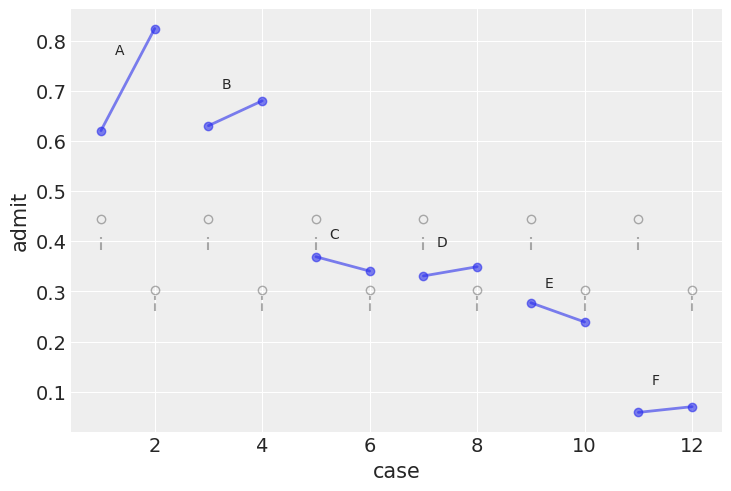

In [11]:
idx = [2 * y for y in range(0, 6)]

for i in idx:
    x = i + 1
    
    y1 = df['fraction_admitted'].values[i]
    y2 = df['fraction_admitted'].values[i + 1]
    
    plt.plot([x, x + 1], [y1, y2], "-C0o", alpha=0.6, lw=2)
    plt.text(x + 0.25, (y1 + y2) / 2 + 0.05, df.dept.values[i])
    
    
    pos_male_desc = df_11_7[f'p__{i}'].describe(percentiles=[0.055, 0.945])
    pos_fem_desc = df_11_7[f'p__{i + 1}'].describe(percentiles=[0.055, 0.945])
    
    male_mean = pos_male_desc.loc['mean']
    male_lo = pos_male_desc.loc['5.5%']
    male_hi = pos_male_desc.loc['94.5%']
        
    fem_mean = pos_fem_desc.loc['mean']
    fem_lo = pos_fem_desc.loc['5.5%']
    fem_hi = pos_fem_desc.loc['94.5%']

    plt.plot(x, male_mean, 'ko', fillstyle="none", alpha=0.3)
    plt.plot(x + 1, fem_mean, 'ko', fillstyle="none", alpha=0.3)
    plt.axvline(x=x, ymin=male_lo, ymax=male_hi, linestyle='--', color='k', alpha=0.3)
    plt.axvline(x=x + 1, ymin=fem_lo, ymax=fem_hi, linestyle='--', color='k', alpha=0.3)
    
plt.xlabel('case')
plt.ylabel('admit')
plt.plot();